In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import catboost as cb

# Loading dataset & pre-processing

In [4]:
df = pd.read_csv("PastLoans.csv")

In [5]:
# encode sex column
df["sex"] = df["sex"].map({"M": 0, "F": 1})

# Encode employment column
df["employment"] = df["employment"].map(
    {"unemployed": 0, "student": 1, "employed": 2, "retired": 3}
)

### Train-test split

In [6]:
X = df.drop(["default", "digital1", "digital2"], axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modeling

[0]	train-auc:0.73581	validation-auc:0.72466
[100]	train-auc:0.74618	validation-auc:0.73328
[200]	train-auc:0.74955	validation-auc:0.73434
[300]	train-auc:0.75307	validation-auc:0.73478
[336]	train-auc:0.75403	validation-auc:0.73457
Ensemble Accuracy: 0.8966
Ensemble Balanced Accuracy: 0.5128704388065934
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     27016
           1       0.32      0.03      0.06      2984

    accuracy                           0.90     30000
   macro avg       0.61      0.51      0.50     30000
weighted avg       0.84      0.90      0.86     30000



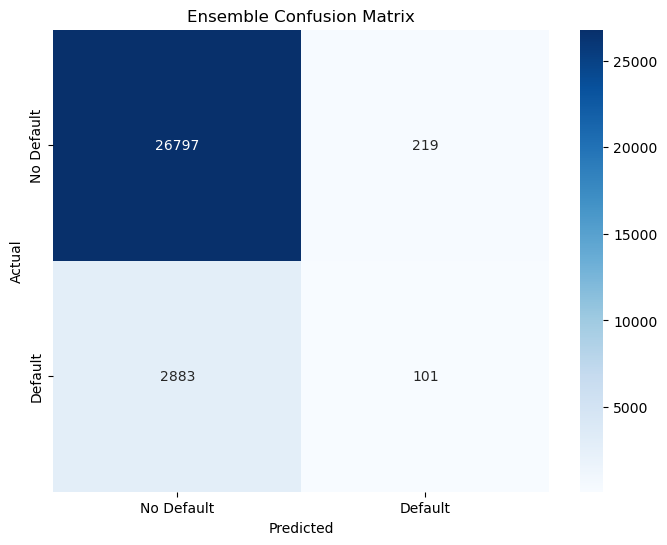

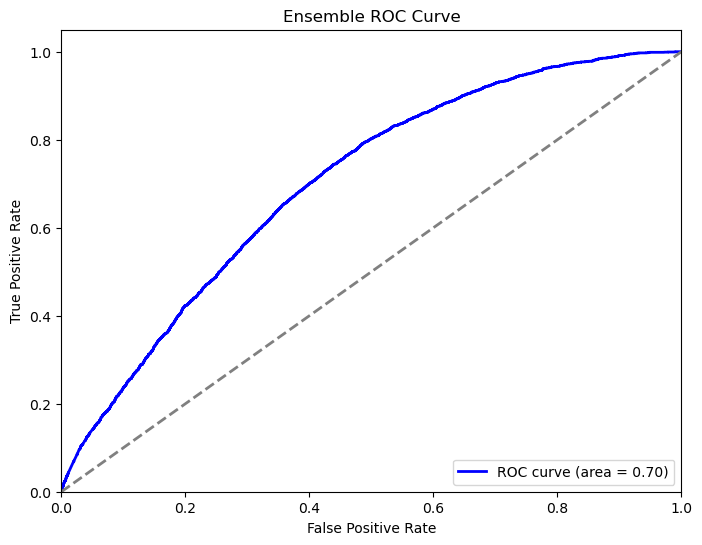

In [7]:
# Assuming X_train, y_train, X_test, y_test are already defined.

# 1. Train the RandomForest model
rf = RandomForestClassifier(n_estimators=1000, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# 2. Train the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "max_depth": 6,
    "scale_pos_weight": y_train.value_counts()[0] / y_train.value_counts()[1],
    "random_state": 42,
    "eval_metric": "auc",
}
evals = [(dtrain, "train"), (dtest, "validation")]

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100,
)

# 3. Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('random_forest', rf),
        ('xgboost', xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False))
    ],
    voting='soft'  # 'soft' uses predicted probabilities to vote, 'hard' uses predicted class labels
)

# 4. Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)

# 6. Performance Metrics
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble Accuracy: {accuracy_ensemble}")
print(f"Ensemble Balanced Accuracy: {balanced_acc_ensemble}")

print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# 7. Confusion Matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_ensemble,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Confusion Matrix")
plt.show()

# 8. ROC Curve and AUC for Ensemble
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_prob_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ensemble, tpr_ensemble, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_ensemble:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [9]:
categorical_features = ["sex", "employment", "married"]

# 1. Train the RandomForest model
rf = RandomForestClassifier(n_estimators=1000, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# 2. Train the CatBoost model
cb_model = cb.CatBoostClassifier(
    iterations=10000,
    learning_rate=0.01,
    depth=6,
    boosting_type="Plain",
    cat_features=categorical_features,
    auto_class_weights="Balanced",
    eval_metric="AUC",
    verbose=100,
    early_stopping_rounds=50
)

cb_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 3. Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('random_forest', rf),
        ('catboost', cb_model)
    ],
    voting='soft'  # 'soft' uses predicted probabilities to vote, 'hard' uses predicted class labels
)

# 4. Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)

# 6. Performance Metrics
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble Accuracy: {accuracy_ensemble}")
print(f"Ensemble Balanced Accuracy: {balanced_acc_ensemble}")

print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# 7. Confusion Matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_ensemble,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Confusion Matrix")
plt.show()

# 8. ROC Curve and AUC for Ensemble
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_prob_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ensemble, tpr_ensemble, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_ensemble:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ensemble)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Locate the index of the largest F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)

Best Threshold: 1


In [ ]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     27016
           1       0.22      0.22      0.22      2984

    accuracy                           0.85     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.84      0.85      0.85     30000



Best Threshold for F1-score: 0.33


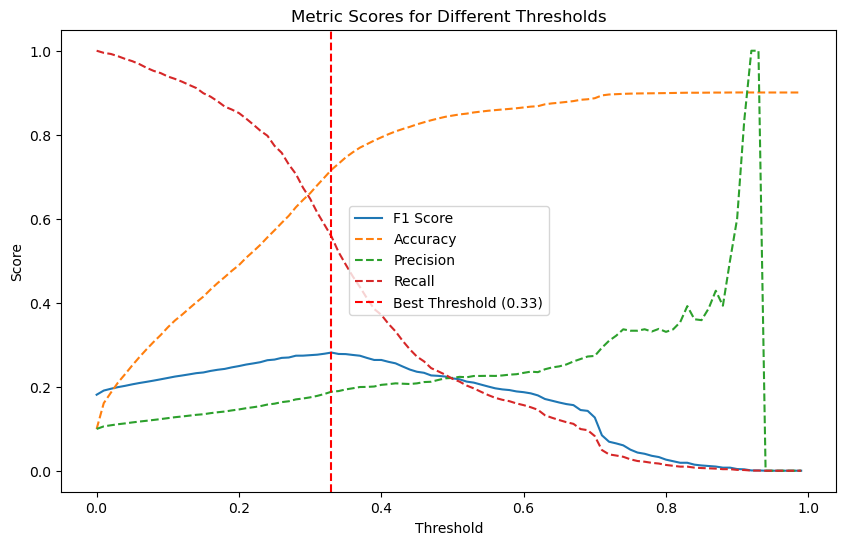

Accuracy: 0.7166666666666667
Precision: 0.18815015829941203
Recall: 0.5576407506702413
F1-Score: 0.28136624957727424


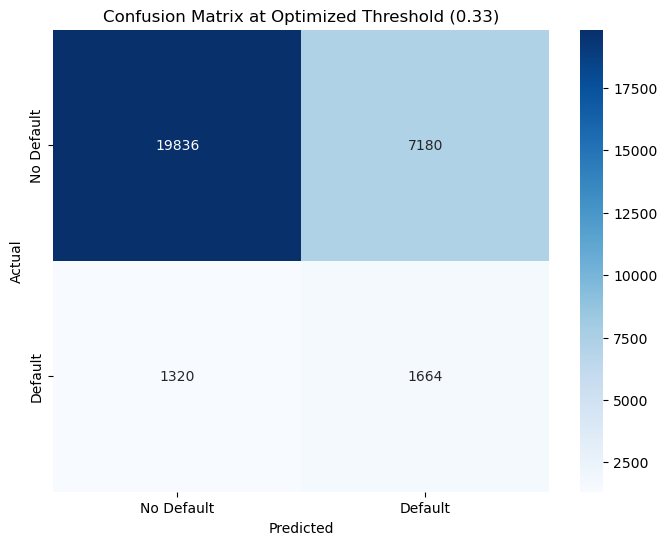

In [ ]:
# Assuming you already have your ensemble model trained and have probabilities:
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds to test
thresholds = np.arange(0.0, 1.0, 0.01)

# Create lists to store metric results for each threshold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate through each threshold and calculate performance metrics
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = np.where(y_prob_ensemble >= threshold, 1, 0)
    
    # Calculate metrics
    accuracy_list.append(accuracy_score(y_test, y_pred_threshold))
    precision_list.append(precision_score(y_test, y_pred_threshold))
    recall_list.append(recall_score(y_test, y_pred_threshold))
    f1_list.append(f1_score(y_test, y_pred_threshold))

# Find the best threshold for F1-score (or you can choose another metric)
best_threshold_idx = np.argmax(f1_list)
best_threshold = thresholds[best_threshold_idx]

print(f"Best Threshold for F1-score: {best_threshold:.2f}")

# Plot F1-score across different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_list, label='F1 Score')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle='--')
plt.plot(thresholds, precision_list, label='Precision', linestyle='--')
plt.plot(thresholds, recall_list, label='Recall', linestyle='--')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metric Scores for Different Thresholds')
plt.legend(loc='best')
plt.show()

# Now, use the best threshold to make final predictions
y_pred_optimized = np.where(y_prob_ensemble >= best_threshold, 1, 0)

# Evaluate the performance with the optimized threshold
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized)}")
print(f"Precision: {precision_score(y_test, y_pred_optimized)}")
print(f"Recall: {recall_score(y_test, y_pred_optimized)}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimized)}")

# Confusion Matrix for Optimized Threshold
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_optimized,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix at Optimized Threshold ({best_threshold:.2f})")
plt.show()
